In [47]:
!pip install mplsoccer statsbombpy
from mplsoccer import VerticalPitch, Pitch, FontManager, Sbopen
import statsbombpy
from statsbombpy import sb




In [52]:
import matplotlib.pyplot as plt

from mplsoccer import VerticalPitch, FontManager, Sbopen

plt.style.use('ggplot')

# get event and lineup dataframes for game 7478
# event data
parser = Sbopen()
df_event, df_related, df_freeze, df_tactics = parser.event(3943043)

# lineup data
df_lineup = parser.lineup(3943043)
df_lineup = df_lineup[['player_id', 'jersey_number', 'team_name']].copy()



In [58]:
match_id = 3943043

# Retrieve events for the match
events = sb.events(match_id)

# Filter the events to find the shots and their IDs
shot_events = events[events['type'] == 'Shot']

# Display shot IDs and related information
shot_ids = shot_events[['id', 'player', 'team', 'minute', 'second']]

# Print the first few shot events
print(shot_ids.head())

                                        id                        player  \
3228  3787ac1c-b077-4960-b717-ce3e7361f8a4     Nicholas Williams Arthuer   
3229  c825856a-5a21-4507-b9e2-ea07b5bf4cca  Robin Aime Robert Le Normand   
3230  dd4098ae-cd79-4d2a-9717-e95b5fd21674                   Declan Rice   
3231  7f58b69c-8311-493f-91dd-d2a57ac07387              Fabián Ruiz Peña   
3232  064d60aa-8976-42ad-9186-b26265fe1d1a          Daniel Olmo Carvajal   

         team  minute  second  
3228    Spain      11      13  
3229    Spain      12      21  
3230  England      16      20  
3231    Spain      27      27  
3232    Spain      34      58  


In [59]:
SHOT_ID = '064d60aa-8976-42ad-9186-b26265fe1d1a'
df_freeze_frame = df_freeze[df_freeze.id == SHOT_ID].copy()
df_shot_event = df_event[df_event.id == SHOT_ID].dropna(axis=1, how='all').copy()

# add the jersey number
df_freeze_frame = df_freeze_frame.merge(df_lineup, how='left', on='player_id')

In [60]:
# strings for team names
team1 = df_shot_event.team_name.iloc[0]
team2 = list(set(df_event.team_name.unique()) - {team1})[0]

# subset the team shooting, and the opposition (goalkeeper/ other)
df_team1 = df_freeze_frame[df_freeze_frame.team_name == team1]
df_team2_goal = df_freeze_frame[(df_freeze_frame.team_name == team2) &
                                (df_freeze_frame.position_name == 'Goalkeeper')]
df_team2_other = df_freeze_frame[(df_freeze_frame.team_name == team2) &
                                 (df_freeze_frame.position_name != 'Goalkeeper')]

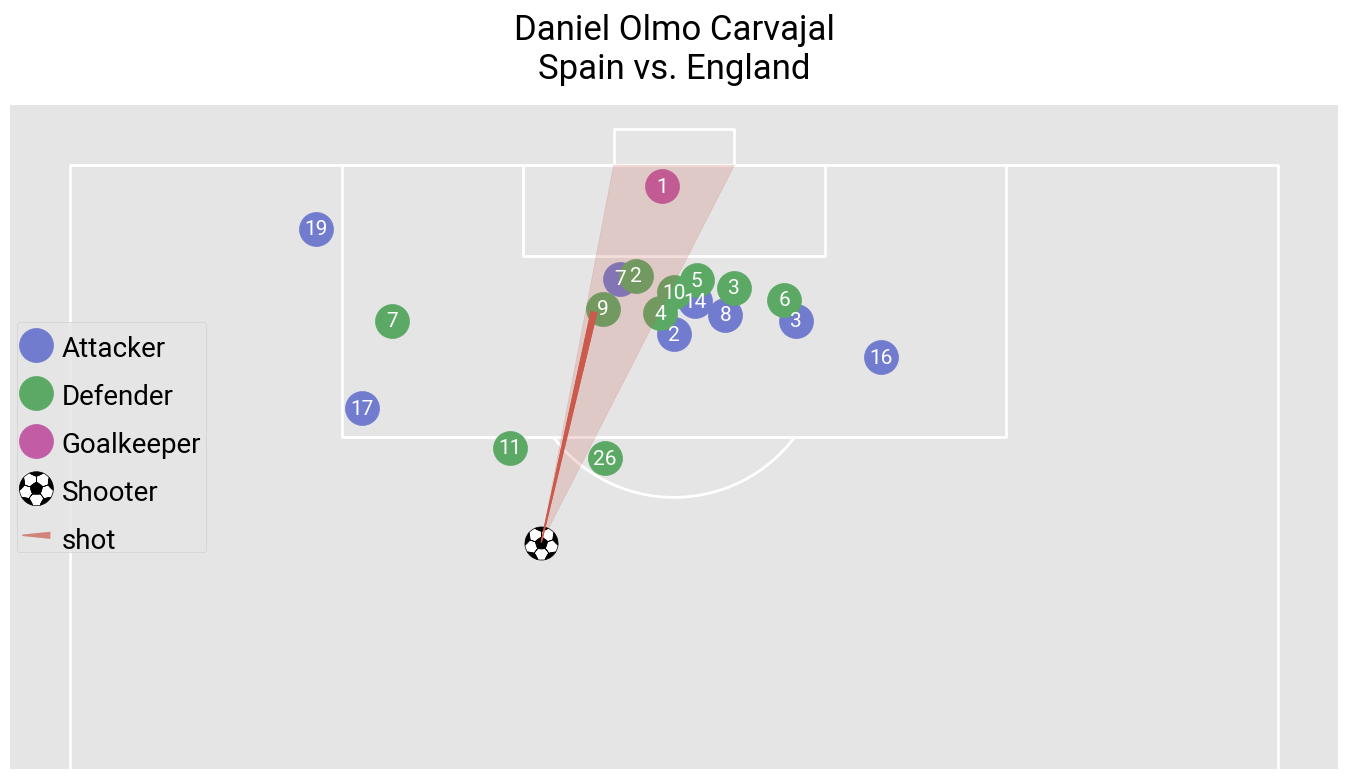

In [61]:
# Setup the pitch
pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-20)

# We will use mplsoccer's grid function to plot a pitch with a title axis.
fig, axs = pitch.grid(figheight=8, endnote_height=0,  # no endnote
                      title_height=0.1, title_space=0.02,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.83)

# Plot the players
sc1 = pitch.scatter(df_team1.x, df_team1.y, s=600, c='#727cce', label='Attacker', ax=axs['pitch'])
sc2 = pitch.scatter(df_team2_other.x, df_team2_other.y, s=600,
                    c='#5ba965', label='Defender', ax=axs['pitch'])
sc4 = pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=600,
                    ax=axs['pitch'], c='#c15ca5', label='Goalkeeper')

# plot the shot
sc3 = pitch.scatter(df_shot_event.x, df_shot_event.y, marker='football',
                    s=600, ax=axs['pitch'], label='Shooter', zorder=1.2)
line = pitch.lines(df_shot_event.x, df_shot_event.y,
                   df_shot_event.end_x, df_shot_event.end_y, comet=True,
                   label='shot', color='#cb5a4c', ax=axs['pitch'])

# plot the angle to the goal
pitch.goal_angle(df_shot_event.x, df_shot_event.y, ax=axs['pitch'], alpha=0.2, zorder=1.1,
                 color='#cb5a4c', goal='right')

# fontmanager for google font (robotto)
robotto_regular = FontManager()

# plot the jersey numbers
for i, label in enumerate(df_freeze_frame.jersey_number):
    pitch.annotate(label, (df_freeze_frame.x[i], df_freeze_frame.y[i]),
                   va='center', ha='center', color='white',
                   fontproperties=robotto_regular.prop, fontsize=15, ax=axs['pitch'])

# add a legend and title
legend = axs['pitch'].legend(loc='center left', labelspacing=1.5)
for text in legend.get_texts():
    text.set_fontproperties(robotto_regular.prop)
    text.set_fontsize(20)
    text.set_va('center')

# title
axs['title'].text(0.5, 0.5, f'{df_shot_event.player_name.iloc[0]}\n{team1} vs. {team2}',
                  va='center', ha='center', color='black',
                  fontproperties=robotto_regular.prop, fontsize=25)

plt.show()  # If you are using a Jupyter notebook you do not need this line